# Kings County Dataset

The Kings County dataset contains house sale prices for Kings County, which includes Seattle. It includes homes sold between May 2014 and May 2015. Alongside sale price, dataset also contains various attributes of each house sold such as number of rooms, square foot and location.

This notebooks aims to answer the below questions:
    1. What are the top 6 house features that are the most important in determining house prices
    2. How much in avg. is the price difference between waterfront houses and non-waterfront houses
    3. Identify the avg. price and transactions per zipcode. Determine if there's any relationship between them
    4. How have avg. house prices faired the last 12 months and when is the best time of the year to sell?
    
Ahead of trying to answer any of the above questions, it is important to conduct the following:
- Import the necessary libraries
- Remove missing values 
- Introduce / manipulate new or existing columns
- Explore various attributes of the dataset
- Remove missing values and potentially outliers


Let's start by importing the necesary python packages for data manipulation and vizualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

Assign the url of the Kings County dataset to a variable called 'url'.

Import the csv dataset using pandas' 'read_csv' method and use the 'parse_dates' argument to convert the 'date' column from a 'str' to a 'datetime' object

In [2]:
url = 'https://raw.githubusercontent.com/Ftan91/Project-1---Kings-County-House-Dataset/master/kc_house_data.csv'
df = pd.read_csv(url, parse_dates = ['date'])

Now, print the first 5 rows of the dataframe to check if the data has been uploaded successfully

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,...,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,...,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,...,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,...,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,...,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


Great! Now to understand the shape of the dataset, print out the dataframe's shape attribute

In [4]:
original_shape = df.shape
print ('Rows: {}'.format(original_shape[0]))
print ('Columns: {} '.format(original_shape[1]))

Rows: 21597
Columns: 21 


Let's start the data cleaning by checking for duplicates and dropping them. Use the dataframe's 'drop_duplicates' method by passing the 'id' column as the subset argument. This checks for any duplicates in id column.

Note: Duplicates in this column could be either:
- house that have been sold twice in the last twelve months or;
- error entry

To simplify future analysis, let's just drop them.

In [5]:
df = df.drop_duplicates(subset = 'id')

print ('Total number of rows dropped: {}'.format(original_shape[0] - df.shape[0]))

Total number of rows dropped: 177


Now, let's define several functions to help us with data cleaning. Exact explanation of each function listed as comments below.

In [6]:
# Define function called 'datatype_search' with one argument which takes in a column name
# This function returns number of unique datatype as well as listing out all datatype in a particular column
def datatype_search(column):
    x = df[column].unique()
    y = set([type(number) for number in x])
    z = len(y)
    return list(y), z

# Define a function called 'data_quality_summary' which takes a dataframe as it's only argument
# This function returns a dataframe which summarises potential data quality issues for each column
def data_quality_summary(data):
    dictionary = {'Feature': [],
                 'Null Entries': [],
                 'No. of unique datatype(s)' : [],
                 'Feature datatype(s)' : [],
                 'Min, Max': []
                 }
    
    for column in data.columns:
        dictionary['Feature'].append(column)
        dictionary['Null Entries'].append(data[column].isnull().sum())
        dictionary['No. of unique datatype(s)'].append(datatype_search(column)[1])
        dictionary['Feature datatype(s)'].append(datatype_search(column)[0])
        dictionary['Min, Max'].append((data[column].min(), data[column].max()))
        
    summary = pd.DataFrame(dictionary)
    return summary

# Define function called null_filler which takes a column as it's only argument
# This function fills in empty cells using unique values in the particular column according to its existing weight
def null_filler(column):
    if column == 'sqft_basement':
        basement_unique = df[df['sqft_basement'] != '?']['sqft_basement'].unique()
        basement_prob = df[df['sqft_basement'] != '?']['sqft_basement'].value_counts(normalize = True)
        return np.random.choice(basement_unique, 1, p= basement_prob)[0]
    else:
        unique = df[df[column].notnull()][column].unique()
        prob = df[df[column].notnull()][column].value_counts(normalize = True)
        return np.random.choice(unique, 1, p= prob)[0]
    
# Define a function called 'year_value' which takes a row as it's only argument
# This function replaces 0 value in the 'yr_renovated' column with the yr_built value
def year_value(row):
    if row["yr_renovated"] == 0.0 or pd.isna(row["yr_renovated"]) == True:
        return row["yr_built"]
    else:
        return row["yr_renovated"]

Rather than using the .info() method, let's use the 'data_quality_summary' function as defined above to print the summary information for each column including missing values, number of datatypes for each column.

Whilst, df.info() might execute this as well, it is not particularly useful for calculating the number of datatype entries in the column. For example, a single column might have both 'str'and 'int64' datatype, however df.info() will only output 'str' as the datatype which is incorrect.

In [7]:
data_quality_summary(df)

,Feature,Null Entries,No. of unique datatype(s),Feature datatype(s),"Min, Max"
0,id,0,1,[<class 'numpy.int64'>],"(1000102, 9900000190)"
1,date,0,1,[<class 'numpy.datetime64'>],"(2014-05-02 00:00:00, 2015-05-27 00:00:00)"
2,price,0,1,[<class 'numpy.float64'>],"(78000.0, 7700000.0)"
3,bedrooms,0,1,[<class 'numpy.int64'>],"(1, 33)"
4,bathrooms,0,1,[<class 'numpy.float64'>],"(0.5, 8.0)"
5,sqft_living,0,1,[<class 'numpy.int64'>],"(370, 13540)"
6,sqft_lot,0,1,[<class 'numpy.int64'>],"(520, 1651359)"
7,floors,0,1,[<class 'numpy.float64'>],"(1.0, 3.5)"
8,waterfront,2353,1,[<class 'numpy.float64'>],"(0.0, 1.0)"
9,view,63,1,[<class 'numpy.float64'>],"(0.0, 4.0)"


As per above, there are clearly some data quality issues here; 
 - the waterfront, view and yr_renovated columns all have multiple null entries
 - the sqft_basement column is of the incorrect 'str' datatype
 - the sqft_basement has incorrect '?' row entries

Let's fix this using the 'null_filler'function as defined above.

In [8]:
missing_values_column = ['yr_renovated', 'waterfront', 'view', 'sqft_basement']

for column in missing_values_column:
    df[column] = df[column].map(lambda x: null_filler(column) if (pd.isnull(x) or x == '?') else x)

Next, convert the 'sqft_basement' column into an 'int64' datatype.

In [9]:
df['sqft_basement'] = df['sqft_basement'].map(lambda x: int(float(x)))

All 3 data quality issues above should now be resolved. Let's recheck our dataset again to confirm our changes.

In [10]:
data_quality_summary(df)

,Feature,Null Entries,No. of unique datatype(s),Feature datatype(s),"Min, Max"
0,id,0,1,[<class 'numpy.int64'>],"(1000102, 9900000190)"
1,date,0,1,[<class 'numpy.datetime64'>],"(2014-05-02 00:00:00, 2015-05-27 00:00:00)"
2,price,0,1,[<class 'numpy.float64'>],"(78000.0, 7700000.0)"
3,bedrooms,0,1,[<class 'numpy.int64'>],"(1, 33)"
4,bathrooms,0,1,[<class 'numpy.float64'>],"(0.5, 8.0)"
5,sqft_living,0,1,[<class 'numpy.int64'>],"(370, 13540)"
6,sqft_lot,0,1,[<class 'numpy.int64'>],"(520, 1651359)"
7,floors,0,1,[<class 'numpy.float64'>],"(1.0, 3.5)"
8,waterfront,0,1,[<class 'numpy.float64'>],"(0.0, 1.0)"
9,view,0,1,[<class 'numpy.float64'>],"(0.0, 4.0)"


Great! Now let's investigate some of the columns. Given there are various columns with the unit 'sqft', it may be worth checking if there are any inconsistencies between them.

Let's take a look at all 'sqft' columns.

In [11]:
sqft_columns = ['sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement']
df[sqft_columns].head()

,sqft_lot,sqft_living,sqft_above,sqft_basement
0,5650,1180,1180,0
1,7242,2570,2170,400
2,10000,770,770,0
3,5000,1960,1050,910
4,8080,1680,1680,0


It looks like the 'sqft_living' column is the sum of 'sqft_above' and 'sqft_basement' columns. 

Let's further sense check if all rows in the 'sqft_living' column are summed up correctly and drop those which are not.

In [12]:
to_drop = df[df['sqft_living'] != df['sqft_above'] + df['sqft_basement']].index
df.drop(to_drop, axis = 0, inplace = True)

Moving on to the 'sqft_lot' column, a simple google search gives the breakdown of: 

### sqft_lot = sqft_living + yard space

As such, let's drop any incorrect rows where sqft_living > sqft_lot

In [13]:
to_drop2 = df[sqft_columns][df.sqft_living > df.sqft_lot].index
df.drop(to_drop2, axis = 0, inplace = True)

print ('Total number of rows dropped so far: {}'.format(original_shape[0] - df.shape[0]))
print ("This figure includes duplicates entries dropped earlier and the dropped rows from the above 'sqft' checks.")

Total number of rows dropped so far: 1228
This figure includes duplicates entries dropped earlier and the dropped rows from the above 'sqft' checks.


Now that we've cleaned the dataset, let's start introducing some new columns which might potentially be useful for answering the 4 questions that were previously laid out. This is also known as the 'feature engineering' process. We can also introduce external data for better analysis, but let's leave that for future projects. Introducing 4 new columns:
- 'month_sold' - to idenfity any trends between month sold and price
- 'day_sold' - to idenfity any trends between day sold and price 
- 'binned_sqft_living' - for better visualization down the line / checking for outliers
- 'binned_sqft_above' - for better visualization down the line / checking for outliers
- 'binned_sqft_living15' - for better visualization down the line / checking for outliers
- 'house_age' - to identify the house age (2016 -  (yr_renovated or yr_built if yr_renovated == 0))

In [14]:
df['month_sold'] = df['date'].dt.month 
df['day_sold'] = df['date'].dt.dayofweek

df['binned_sqft_living'] = pd.qcut(df['sqft_living'], q = 10) # splits the dataset into 10 equal sized bins
df['binned_sqft_above'] = pd.qcut(df['sqft_above'], q = 10) # same as above
df['binned_sqft_living15'] = pd.qcut(df['sqft_living15'], q = 10) # same as above

df['yr_built_vs_reno'] = df.apply(lambda row: year_value(row), axis = 1) # only a column for the below
df['house_age'] = 2016 - df['yr_built_vs_reno']

Check if the new columns have indeed been introduced.

In [15]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month_sold', 'day_sold',
       'binned_sqft_living', 'binned_sqft_above', 'binned_sqft_living15',
       'yr_built_vs_reno', 'house_age'],
      dtype='object')

Ahead of visualizing the variable distributions, let's split the columns into 'continuous' and 'ordinal_and_categorical' for better visualization.

In [16]:
continuous = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'house_age']
ordinal_and_categorical = ['grade', 'condition', 'floors', 'view', 'waterfront']

Now, let's plot a pairplot for 'continuous' variables and barcharts for 'ordinal_and_categorical' to get a sense of  variable distributions and check for outliers

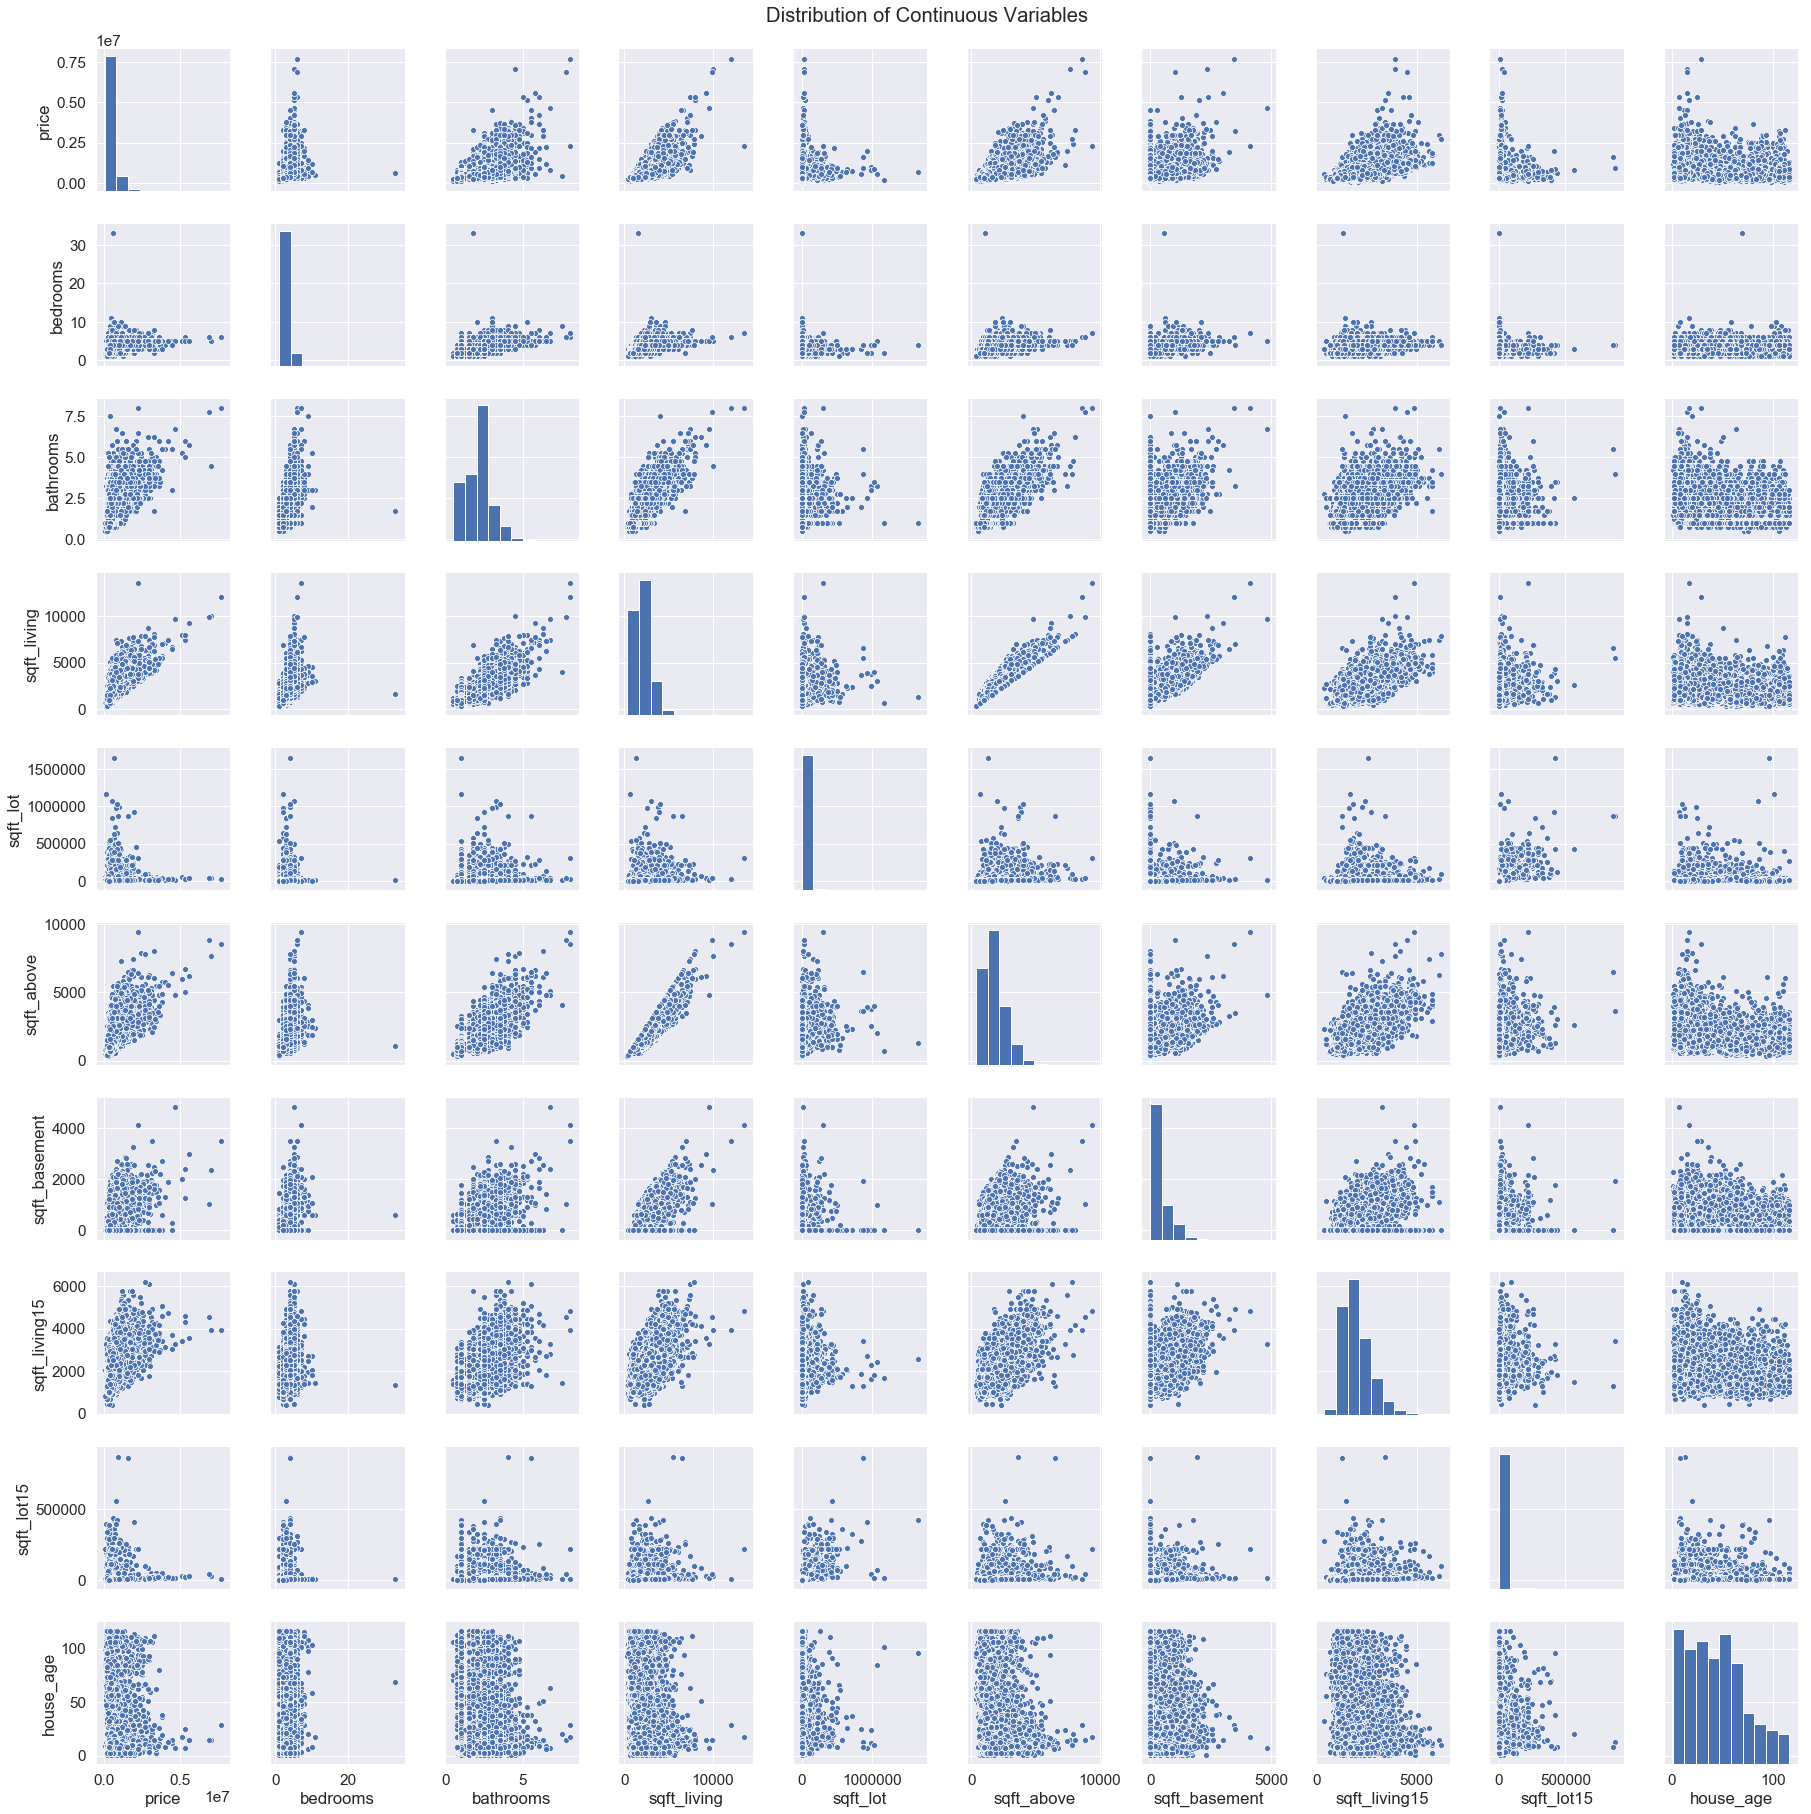

In [17]:
sns.set(font_scale = 1.4)
ax = sns.pairplot(df[continuous])
ax.fig.suptitle('Distribution of Continuous Variables', y = 1.01)
plt.show()

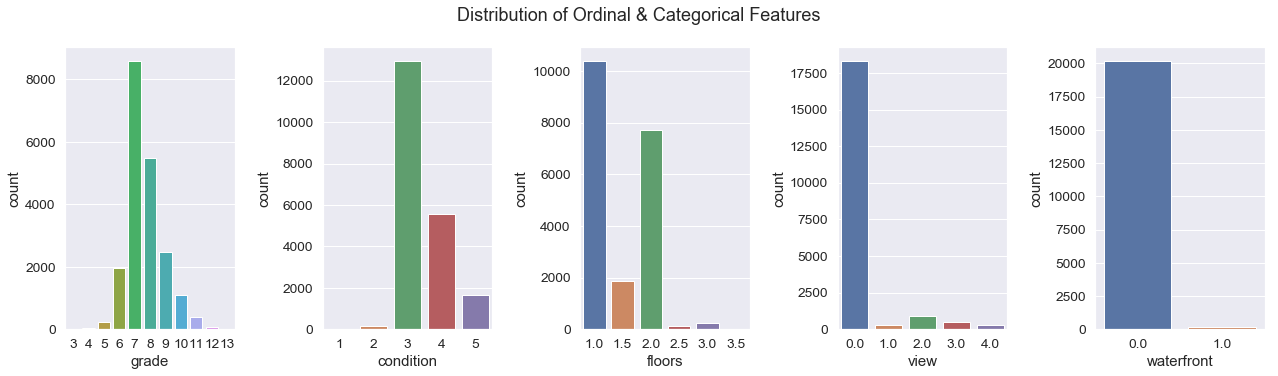

In [18]:
sns.set(font_scale = 1.25)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 5, tight_layout = True, figsize = (18, 5))
ax = [ax1, ax2, ax3, ax4, ax5]
fig.suptitle('Distribution of Ordinal & Categorical Features', y =1.05)

for i in range(len(ordinal_and_categorical)):
    sns.countplot(x = ordinal_and_categorical[i], data = df, ax = ax[i])
plt.show()

As noted above, majority of variables above do not exhibit normal distribution. They do however, exhibit more of a positive skew distribution likely caused by outliers. That being said, variable normality is not a requirement for a linear regression model.
Only model errors are required to be normally distibuted.

Let's now check for outliers in the continuous columns and identify if they should or should not be removed. Using bins makes it easier to identify outliers.

In [19]:
for column in df[continuous].columns:
    print (df[column].value_counts(bins = 10, sort = False))
    print ('\n')

(70377.999, 840200.0]     17905
(840200.0, 1602400.0]      2049
(1602400.0, 2364600.0]      288
(2364600.0, 3126800.0]       89
(3126800.0, 3889000.0]       26
(3889000.0, 4651200.0]        4
(4651200.0, 5413400.0]        4
(5413400.0, 6175600.0]        1
(6175600.0, 6937800.0]        1
(6937800.0, 7700000.0]        2
Name: price, dtype: int64


(0.967, 4.2]    18506
(4.2, 7.4]       1840
(7.4, 10.6]        21
(10.6, 13.8]        1
(13.8, 17.0]        0
(17.0, 20.2]        0
(20.2, 23.4]        0
(23.4, 26.6]        0
(26.6, 29.8]        0
(29.8, 33.0]        1
Name: bedrooms, dtype: int64


(0.491, 1.25]    3824
(1.25, 2.0]      6111
(2.0, 2.75]      8028
(2.75, 3.5]      1866
(3.5, 4.25]       361
(4.25, 5.0]       137
(5.0, 5.75]        26
(5.75, 6.5]        10
(6.5, 7.25]         2
(7.25, 8.0]         4
Name: bathrooms, dtype: int64


(356.829, 1687.0]     7590
(1687.0, 3004.0]      9778
(3004.0, 4321.0]      2515
(4321.0, 5638.0]       386
(5638.0, 6955.0]        70
(6955.0, 8272.

Most outliers look fairly legitimate in comparison to other columns. Two row values however does raise the question of validity and through using some common sense (by sense checking value against other columns), these have been removed.

In [20]:
df.drop(df[df.bedrooms > 20].index, axis = 0, inplace = True)
df.drop(df[(df['sqft_lot'] > 1100000) & (df['sqft_lot'] <1200000)].index, axis = 0, inplace = True)

Now, the dataset should be ready for conducting further analysis and for implementing regression models.

## 1. The top 6 house features that are the most important in determining house prices

In order to understand feature importance to price, it is worth plotting a correlation matrix as per below.

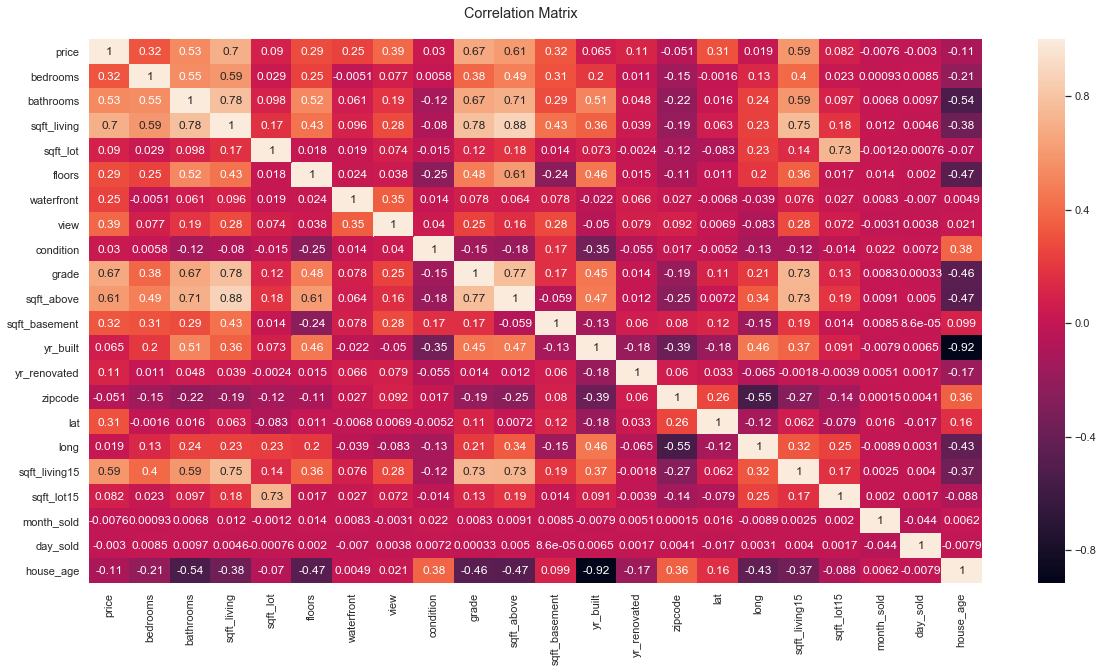

In [21]:
columns_to_drop = ['id', 'date', 'yr_built_vs_reno']
new_df = df.drop(columns_to_drop, axis = 1)
correlation_matrix = new_df.corr()

sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize = (20,10))
fig.suptitle('Correlation Matrix', x = 0.425, y = 0.925)
sns.heatmap(correlation_matrix, annot = True, ax = ax)
plt.show()

Now let's pick out the top 10 variables with the highest correlation to price.

In [22]:
x = correlation_matrix['price'].sort_values(ascending = False)
top10_price_correlation = x[:10]
top10_price_correlation

price           1.00
sqft_living     0.70
grade           0.67
sqft_above      0.61
sqft_living15   0.59
bathrooms       0.53
view            0.39
sqft_basement   0.32
bedrooms        0.32
lat             0.31
Name: price, dtype: float64

Now, having a general sense of the correlations, let's filter this down to the top 6 features (excluding the price column)

In [23]:
top6_price_correlation = top10_price_correlation[1:7]
top6_price_correlation

sqft_living     0.70
grade           0.67
sqft_above      0.61
sqft_living15   0.59
bathrooms       0.53
view            0.39
Name: price, dtype: float64

Great! From a simple linear regression perspective, we now have the top 6 features that are correlated to price which solves our first question! We can confirm this with simple scatter plots.

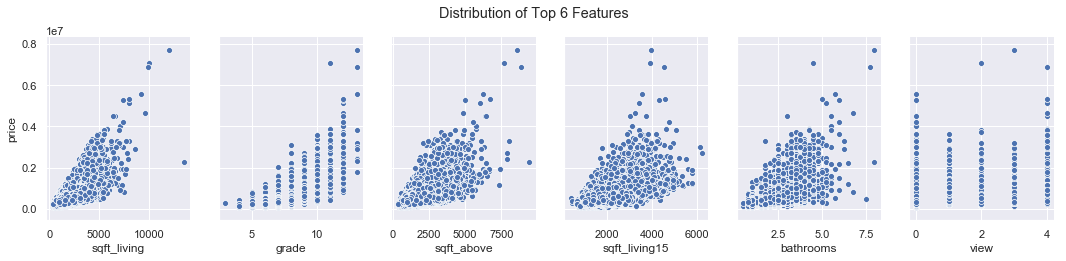

In [24]:
ax = sns.pairplot(data = df, y_vars=['price'], x_vars = top6_price_correlation.index)
ax.fig.suptitle('Distribution of Top 6 Features', y = 1)
ax.fig.set_size_inches(15,4)
plt.show()

As suspected, these features have some form of positive relationship with price. Note the 'view' column is fairly dubious, which can be confirmed by the fairly weak correlation at 0.39 and also can be viewed as an ordinal type feature, hence the stacked distribution

<!-- Kde is better than hist because its not affected by the number of bins

As you can see above, majority of features do not follow a normal distribution however this is not a condition for linear regression (errors need to be normally distributed - this can be done through a QQ plot) -->

Now that we have identify the top 6 variables, let's dig deeper into how each variable performs in a simple linear regression model.

As we are about to iterate a simple linear regression / OLS on each of the variable above, it would be useful to create a function to display the summary of attributes for each model.

In [25]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

def OLS_summary(feature_correlations, data, scale):
    summary = {'feature' : [], 
           'Pearson_r'  : [], 
           'Pearson_r2' : [], 
           'R2' : [], 
           'P_value': [],
           'Coef_value' : [],
            'Coef_interval' : [],
           'F_value' : [],
           'T_value' : [],
            'Jacque-Bera' : [],
           'Resid. Skew': [],
           'Resid. Kurtosis': []
          }

    if scale == 'normal':    
        for index in range(len(feature_correlations)):
            f = 'price~' + feature_correlations.index[index]
            model = ols(formula = f, data = data).fit()
            summary['feature'].append(feature_correlations.index[index])
            summary['Pearson_r'].append(round(feature_correlations[index],2))
            summary['Pearson_r2'].append(round(feature_correlations[index] ** 2,2))
            summary['R2'].append(round(model.rsquared,2))
            summary['P_value'].append(round(model.pvalues[1],2))
            summary['F_value'].append(round(model.fvalue,2))
            summary['T_value'].append(round(model.tvalues[1],2))
            summary['Resid. Skew'].append(round(sms.jarque_bera(model.resid)[2],2))
            summary['Resid. Kurtosis'].append(round(sms.jarque_bera(model.resid)[-1],2))
            summary['Jacque-Bera'].append(round(sms.jarque_bera(model.resid)[0],2))
            summary['Coef_value'].append(round(model.params[1],2))
            x = model.conf_int(alpha = 0.05, cols = None)
            y = [round(x.loc[feature_correlations.index[index], 0],2), round(x.loc[feature_correlations.index[index], 1],2)]
            summary['Coef_interval'].append(y)
        summary_df = pd.DataFrame(summary)
        return summary_df
    elif scale == 'log':
        for index in range(len(feature_correlations)):
            f = 'price_log~' + feature_correlations.index[index]
            model = ols(formula = f, data = data).fit()
            summary['feature'].append(feature_correlations.index[index])
            summary['Pearson_r'].append(round(feature_correlations[index],2))
            summary['Pearson_r2'].append(round(feature_correlations[index] ** 2,2))
            summary['R2'].append(round(model.rsquared,2))
            summary['P_value'].append(round(model.pvalues[1],2))
            summary['F_value'].append(round(model.fvalue,2))
            summary['T_value'].append(round(model.tvalues[1],2))
            summary['Resid. Skew'].append(round(sms.jarque_bera(model.resid)[2],2))
            summary['Resid. Kurtosis'].append(round(sms.jarque_bera(model.resid)[-1],2))
            summary['Jacque-Bera'].append(round(sms.jarque_bera(model.resid)[0],2))
            summary['Coef_value'].append(round(model.params[1],2))
            x = model.conf_int(alpha = 0.05, cols = None)
            y = [round(x.loc[feature_correlations.index[index], 0],2), round(x.loc[feature_correlations.index[index], 1],2)]
            summary['Coef_interval'].append(y)
        summary_df = pd.DataFrame(summary)
        return summary_df
    else:
        for index in range(len(feature_correlations)):
            f = 'price_minmax~' + feature_correlations.index[index]
            model = ols(formula = f, data = data).fit()
            summary['feature'].append(feature_correlations.index[index])
            summary['Pearson_r'].append(round(feature_correlations[index],2))
            summary['Pearson_r2'].append(round(feature_correlations[index] ** 2,2))
            summary['R2'].append(round(model.rsquared,2))
            summary['P_value'].append(round(model.pvalues[1],2))
            summary['F_value'].append(round(model.fvalue,2))
            summary['T_value'].append(round(model.tvalues[1],2))
            summary['Resid. Skew'].append(round(sms.jarque_bera(model.resid)[2],2))
            summary['Resid. Kurtosis'].append(round(sms.jarque_bera(model.resid)[-1],2))
            summary['Jacque-Bera'].append(round(sms.jarque_bera(model.resid)[0],2))
            summary['Coef_value'].append(round(model.params[1],2))
            x = model.conf_int(alpha = 0.05, cols = None)
            y = [round(x.loc[feature_correlations.index[index], 0],2), round(x.loc[feature_correlations.index[index], 1],2)]
            summary['Coef_interval'].append(y)
        summary_df = pd.DataFrame(summary)
        return summary_df

Now let's put our function to the test on our top 6 features!

In [26]:
model = list(top6_price_correlation.index) + ['price']
df_model = df[model]

print ('Simple Linear Regression: ')
OLS_summary(top6_price_correlation, df_model, 'normal')

Simple Linear Regression: 


,feature,Pearson_r,Pearson_r2,R2,P_value,Coef_value,Coef_interval,F_value,T_value,Jacque-Bera,Resid. Skew,Resid. Kurtosis
0,sqft_living,0.70,0.49,0.49,0.00,283.22,"[279.29, 287.15]","19,946.38",141.23,"505,364.18",2.84,26.73
1,grade,0.67,0.45,0.45,0.00,"210,704.90","[207497.09, 213912.7]","16,576.04",128.75,"1,911,586.28",4.08,49.75
2,sqft_above,0.61,0.37,0.37,0.00,269.66,"[264.8, 274.52]","11,819.85",108.72,"684,045.21",3.29,30.62
3,sqft_living15,0.59,0.35,0.35,0.00,317.26,"[311.26, 323.27]","10,727.49",103.57,"1,810,299.68",4.25,48.40
4,bathrooms,0.53,0.28,0.28,0.00,"257,638.93","[252033.58, 263244.27]","8,116.44",90.09,"818,877.27",3.44,33.29
5,view,0.39,0.15,0.15,0.00,"189,255.84","[183140.45, 195371.23]","3,679.58",60.66,"992,244.33",3.66,36.40


Couple of things to notice:
    - R2 is exactly the same as the square of pearson's correlation (proves that model is running correctly)
    - All p-values are 0, representing the probability of getting a 0 coef_value (due to chance) is 0%
    - Model does not satisfy the assumptions of linear regression specifically on the residual of errors:
        - Proven by fairly high JB values (ie. more than 6 implies non-normal distribution)
        - Skew of more than 0 (all feature exhibitts positve skew)
        - Significantly high kurtosis (kurtosis of 3 is equivalent to a normal peak)


Let's try to improve model performance through either minmax scaling or log-transforming the features and target variable. Also, remember to remove the 'view' column when log transforming as it is not possible to log transform 0 values.

Starting off with minmax scaling which transforms values to between 0 and 1.

In [27]:
df_model_minmax = df_model.copy()

for feature in df_model_minmax.columns:
    d_min = df_model_minmax[feature].min()
    d_max = df_model_minmax[feature].max()
    df_model_minmax[feature] = (df_model_minmax[feature] - d_min) / (d_max - d_min)
    
df_model_minmax.columns = ['sqft_living_minmax', 'grade_minmax', 'sqft_above_minmax', 'sqft_living15_minmax', 'bathrooms_minmax', 'view_minmax', 'price_minmax']
top6_price_corr_minmax = df_model_minmax.corr()['price_minmax'].drop(['price_minmax'], axis = 0).sort_values(ascending = False)

print ('Simple Linear Regression with minmax scaling: ')
OLS_summary(top6_price_corr_minmax, df_model_minmax, 'minmax')

Simple Linear Regression with minmax scaling: 


,feature,Pearson_r,Pearson_r2,R2,P_value,Coef_value,Coef_interval,F_value,T_value,Jacque-Bera,Resid. Skew,Resid. Kurtosis
0,sqft_living_minmax,0.70,0.49,0.49,0.00,0.49,"[0.48, 0.5]","19,946.38",141.23,"505,364.18",2.84,26.73
1,grade_minmax,0.67,0.45,0.45,0.00,0.28,"[0.27, 0.28]","16,576.04",128.75,"1,911,586.28",4.08,49.75
2,sqft_above_minmax,0.61,0.37,0.37,0.00,0.32,"[0.31, 0.33]","11,819.85",108.72,"684,045.21",3.29,30.62
3,sqft_living15_minmax,0.59,0.35,0.35,0.00,0.24,"[0.24, 0.25]","10,727.49",103.57,"1,810,299.68",4.25,48.40
4,bathrooms_minmax,0.53,0.28,0.28,0.00,0.25,"[0.25, 0.26]","8,116.44",90.09,"818,877.27",3.44,33.29
5,view_minmax,0.39,0.15,0.15,0.00,0.10,"[0.1, 0.1]","3,679.58",60.66,"992,244.33",3.66,36.40


Looks like there are no improvements in the model apart from smaller coef_values and narrower intervals.

Moving on with log transforming our features and target variable.

In [28]:
df_model_log = np.log(df_model)
df_model_log.columns = ['sqft_living_log', 'grade_log', 'sqft_above_log', 'sqft_living15_log', 'bathrooms_log', 'view_log', 'price_log']
top5_log_corr = df_model_log.corr()['price_log'].drop(['view_log','price_log'], axis = 0).sort_values(ascending = False)

print ('Simple Linear Regression with log transformation: ')
OLS_summary(top5_log_corr, df_model_log, 'log')

Simple Linear Regression with log transformation: 


,feature,Pearson_r,Pearson_r2,R2,P_value,Coef_value,Coef_interval,F_value,T_value,Jacque-Bera,Resid. Skew,Resid. Kurtosis
0,grade_log,0.70,0.48,0.48,0.00,2.46,"[2.42, 2.49]","19,104.77",138.22,177.66,0.21,3.20
1,sqft_living_log,0.68,0.46,0.46,0.00,0.85,"[0.83, 0.86]","17,368.29",131.79,144.28,0.18,2.79
2,sqft_living15_log,0.61,0.38,0.38,0.00,1.00,"[0.98, 1.01]","12,344.20",111.10,531.41,0.32,3.46
3,sqft_above_log,0.59,0.35,0.35,0.00,0.73,"[0.72, 0.74]","10,850.75",104.17,171.21,0.21,2.87
4,bathrooms_log,0.53,0.28,0.28,0.00,0.71,"[0.69, 0.72]","7,765.76",88.12,285.71,0.29,3.07


Comparing both log-transform and non-log transform data, we can see improvements in:
    - R2 values (except sqft_living) though is fairly marginal
    - Narrower confidence_interval
    - More uniform residuals as seen by the JB, skewness and kurtosis values
    
Let's now visually take the 'sqft_living' feature across both untransformed and log transformed and plot them to visually check the fitted model and the residuals as well. We can use the statsmodel's .graphics.plot_regress_exog method for this.

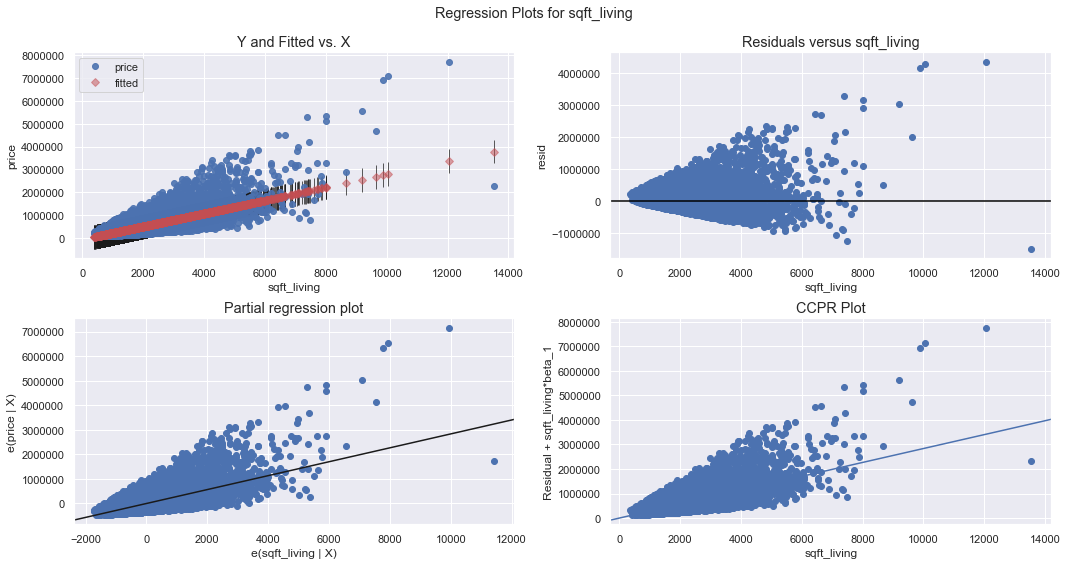

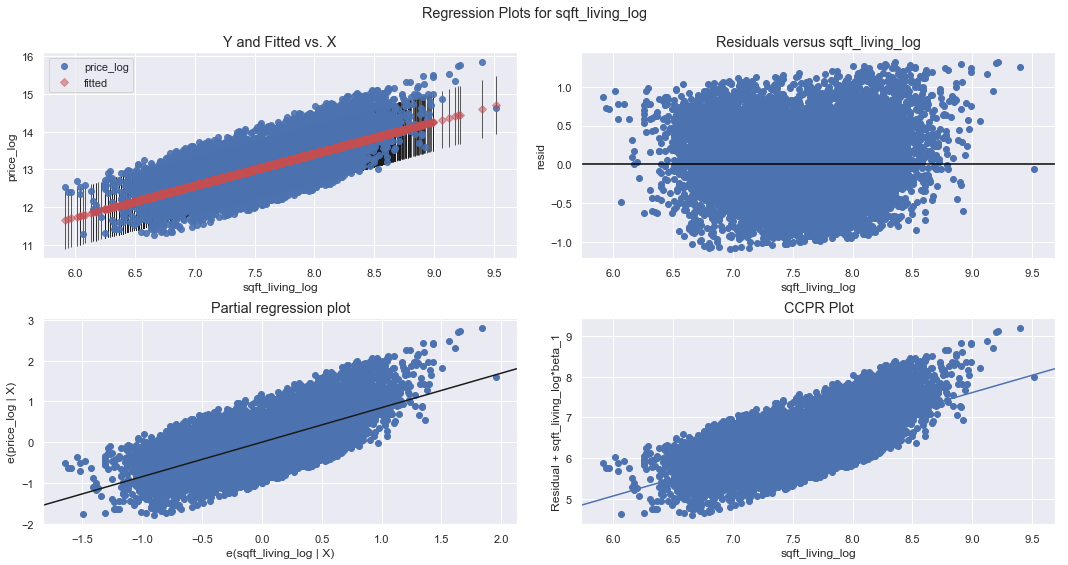

In [29]:
example_features = ['sqft_living', 'sqft_living_log']
target_features = ['price', 'price_log']
example_models = [df_model, df_model_log]
ols_models = []

for i in range(len(example_features)):
    f = target_features[i] + '~' + example_features[i]
    model = ols(formula = f, data = example_models[i]).fit()
    ols_models.append(model)


fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(ols_models[0], example_features[0], fig=fig)
plt.show()

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(ols_models[1], example_features[1], fig=fig)
plt.show()

Once conclusion that can be made is that the residuals (top right) for the log-transformed model is now more uniform across the independent feature. 

### Good stuff, now we have our top 6 features which should hopefully answer the first question!

Also if you're interested, we can also try and execute a Multiple Linear Regression model which includes the rest of the remaining features to check if there are any improvement in R2 values.

The first step ahead of conducting a multiple linear regression model is to try our best to reduce the impact of multicollinearity between independent variables. As such, let's drop any features with > 0.8 correlation.

We can use the previous correlation_matrix and subset the table to the top half triangle which allows us to filter for our correlation threshold.

In [30]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_drop

['sqft_above']

On a 0.8 correlation threshold, we have filtered out the 'sqft_above' feature. We can drop the this feature from the rest of the features ahead of fitting our multiple regression model

In [31]:
multiple_features = list(upper.drop(to_drop, axis = 1).columns)
del (multiple_features[0])

str_join = '+'.join(multiple_features)
f = 'price~' + str_join
model = ols(formula = f, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2364.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:29:17   Log-Likelihood:            -2.7795e+05
No. Observations:               20367   AIC:                         5.559e+05
Df Residuals:                   20346   BIC:                         5.561e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.058e+07   3.09e+06      3.430      0.001    4.54e+06    1.66e+07
bedrooms      -3.939e+04   2069.524    -19.034      0.000   -4.34e+04   -3.53e+04
bathrooms      4.425e+04   3464.101     12.775      0.000    3.75e+04     5.1e+04
sqft_living     191.5260      3.918     48.878      0.000     183.845     199.206
sqft_lot          0.1039      0.052      2.009      0.045       0.003       0.205
floors        -3601.5244   4063.564     -0.886      0.375   -1.16e+04    4363.389
waterfront     5.163e+05    1.7e+04     30.289      0.000    4.83e+05     5.5e+05
view           5.826e+04   2181.246     26.708      0.000     5.4e+04    6.25e+04
condition       2.71e+04   2427.543     11.164      0.000    2.23e+04    3.19e+04
grade          9.408e+04   2267.963     41.483      0.000    8.96e+04    9.85e+04
sqft_basement   -40.7063      4.624     -8.804      0.000     -49.769     -31.643
yr_built      -2872.6003    243.492    -11.797      0.000   -3349.865   -2395.336
yr_renovated     18.2197      7.074      2.576      0.010       4.354      32.086
zipcode        -606.9295     34.205    -17.744      0.000    -673.973    -539.886
lat            5.955e+05   1.11e+04     53.598      0.000    5.74e+05    6.17e+05
long          -2.097e+05   1.37e+04    -15.307      0.000   -2.37e+05   -1.83e+05
sqft_living15    21.5945      3.573      6.044      0.000      14.592      28.597
sqft_lot15       -0.3805      0.077     -4.917      0.000      -0.532      -0.229
month_sold    -2870.5608    462.003     -6.213      0.000   -3776.123   -1964.998
day_sold       -148.6592    982.886     -0.151      0.880   -2075.195    1777.877
house_age       -91.7985    247.362     -0.371      0.711    -576.649     393.052
==============================================================================
Omnibus:                    17170.095   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1634448.652
Skew:                           3.535   Prob(JB):                         0.00
Kurtosis:                      46.313   Cond. No.                     2.17e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As notified above, we have generated a fairly reasonable R2 figure of 70% under the multiple regression model however there still remains strong collinearity as warned above. 

One way to solve this is by using a rescaling our predictor and target features to between 0 and 1.

In [32]:
df_model2 = df.copy()

for feature in multiple_features:
    d_min = df_model2[feature].min()
    d_max = df_model2[feature].max()
    df_model2[feature] = (df_model2[feature] - d_min) / (d_max - d_min)

price_min = df_model2['price'].min()
price_max = df_model2['price'].max()
df_model2['price'] = (df_model2['price'] - price_min) / (price_max - price_min)

df_model2

str_join = '+'.join(multiple_features)
f = 'price~' + str_join
model = ols(formula = f, data = df_model2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2364.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:29:17   Log-Likelihood:                 44796.
No. Observations:               20367   AIC:                        -8.955e+04
Df Residuals:                   20346   BIC:                        -8.938e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0384      0.004     -9.648      0.000      -0.046      -0.031
bedrooms         -0.0517      0.003    -19.034      0.000      -0.057      -0.046
bathrooms         0.0435      0.003     12.775      0.000       0.037       0.050
sqft_living       0.3309      0.007     48.878      0.000       0.318       0.344
sqft_lot          0.0225      0.011      2.009      0.045       0.001       0.044
floors           -0.0012      0.001     -0.886      0.375      -0.004       0.001
waterfront        0.0677      0.002     30.289      0.000       0.063       0.072
view              0.0306      0.001     26.708      0.000       0.028       0.033
condition         0.0142      0.001     11.164      0.000       0.012       0.017
grade             0.1234      0.003     41.483      0.000       0.118       0.129
sqft_basement    -0.0257      0.003     -8.804      0.000      -0.031      -0.020
yr_built         -0.0433      0.004    -11.797      0.000      -0.051      -0.036
yr_renovated      0.0048      0.002      2.576      0.010       0.001       0.008
zipcode          -0.0158      0.001    -17.744      0.000      -0.018      -0.014
lat               0.0486      0.001     53.598      0.000       0.047       0.050
long             -0.0331      0.002    -15.307      0.000      -0.037      -0.029
sqft_living15     0.0165      0.003      6.044      0.000       0.011       0.022
sqft_lot15       -0.0435      0.009     -4.917      0.000      -0.061      -0.026
month_sold       -0.0041      0.001     -6.213      0.000      -0.005      -0.003
day_sold         -0.0001      0.001     -0.151      0.880      -0.002       0.001
house_age        -0.0014      0.004     -0.371      0.711      -0.009       0.006
==============================================================================
Omnibus:                    17170.095   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1634448.652
Skew:                           3.535   Prob(JB):                         0.00
Kurtosis:                      46.313   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, the condition number has now reduced but still more than 30. Another problem remains, there are several features with p_values of more than 0.05 (day_sold, house_age and floors). Running them on the side does not have any improvement. 

Let's also visualize all the features and rank them by values.

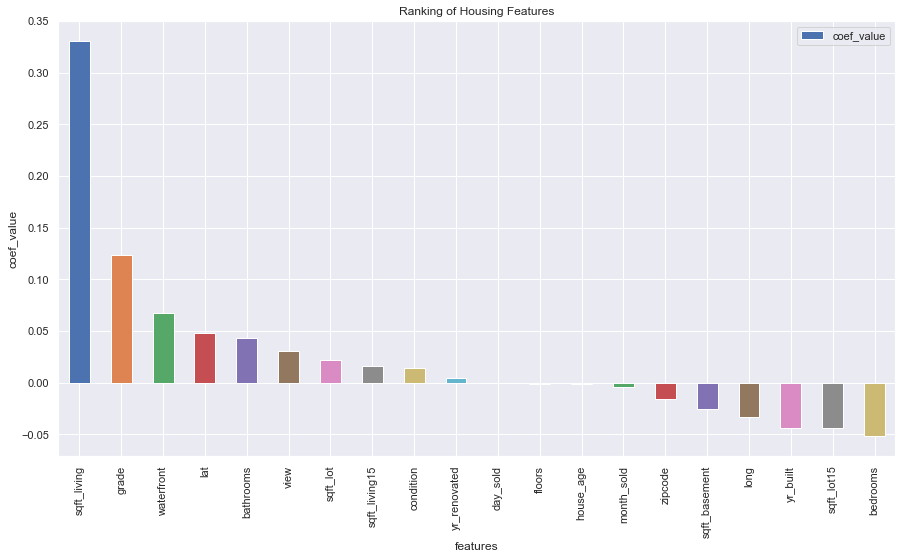

In [33]:
model_params = model.params
x = model_params.reset_index()
x.columns = ['features', 'coef_value']
x.drop(0, axis = 0, inplace = True)
x.sort_values(by = 'coef_value', ascending = False, inplace = True)

ax = x.plot.bar(x = 'features', y = 'coef_value', figsize = (15, 8), title = 'Ranking of Housing Features')
plt.ylabel('coef_value')
plt.show()

One of the issues encountered is the fact that the first 6 features do not tie in with out earlier top 6 features when we did the simple linear regression. For example, the 'waterfront and 'lat' are now within the top 6. Nonetheless we can confirm that our earlier top 6 features are at least within the top 8!

We also can see that the 3 features that have > 0.05 p_value have coef_value of close to 0

Also the multiple linear regression model is probably not the best model for the task given the assumptions have not been satisfied.

## 2. What are the average price difference between waterfront and non-waterfront houses

In order to have a general feel, let's plot a scatter plot of longitude and latitude, with a heatmap according to house prices.

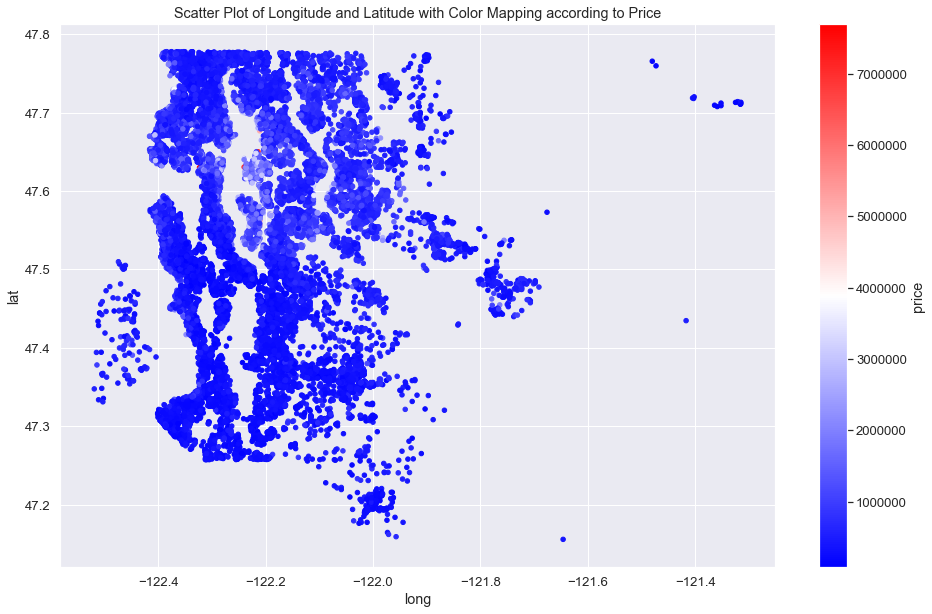

In [52]:
sns.set(font_scale = 1.2)

df.plot(kind = 'scatter', 
        x = 'long', 
        y = 'lat', 
        figsize = (16,10), 
        c= 'price', 
        cmap = 'bwr', 
        colorbar = True, 
        sharex = False,
       title = 'Scatter Plot of Longitude and Latitude with Color Mapping according to Price')
plt.show()

As per above, waterfront houses tend to have higher color density. We can identify this just by looking at houses near beds of water. To identify what is the average price difference, the below is plotted.

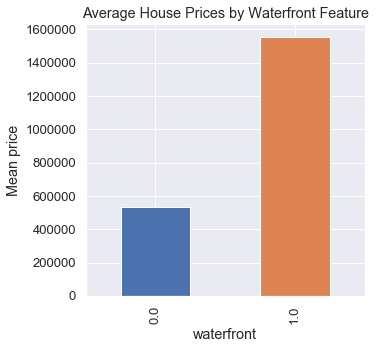

In [35]:
waterfront_general = df.groupby('waterfront')['price'].mean()
waterfront_general.plot.bar(figsize = (5,5), title = 'Average House Prices by Waterfront Feature')
plt.ylabel('Mean price')
plt.show()

On average, waterfront house cost c. around $1m than non-waterfront houses. 

For those interested in buying / selling waterfronts, below are the general differences in price based on the first 6 main features identified earlier.

In [36]:
top6_price_correlation_list = top6_price_correlation.index.tolist()
final = ['binned_sqft_living', 'binned_sqft_above', 'binned_sqft_living15'] + top6_price_correlation_list
del (final[5:7])
del (final[3])

groupby_list = []
for feature in final:
    groupby_list.append(df.groupby(['waterfront', feature])['price'].mean().reset_index())

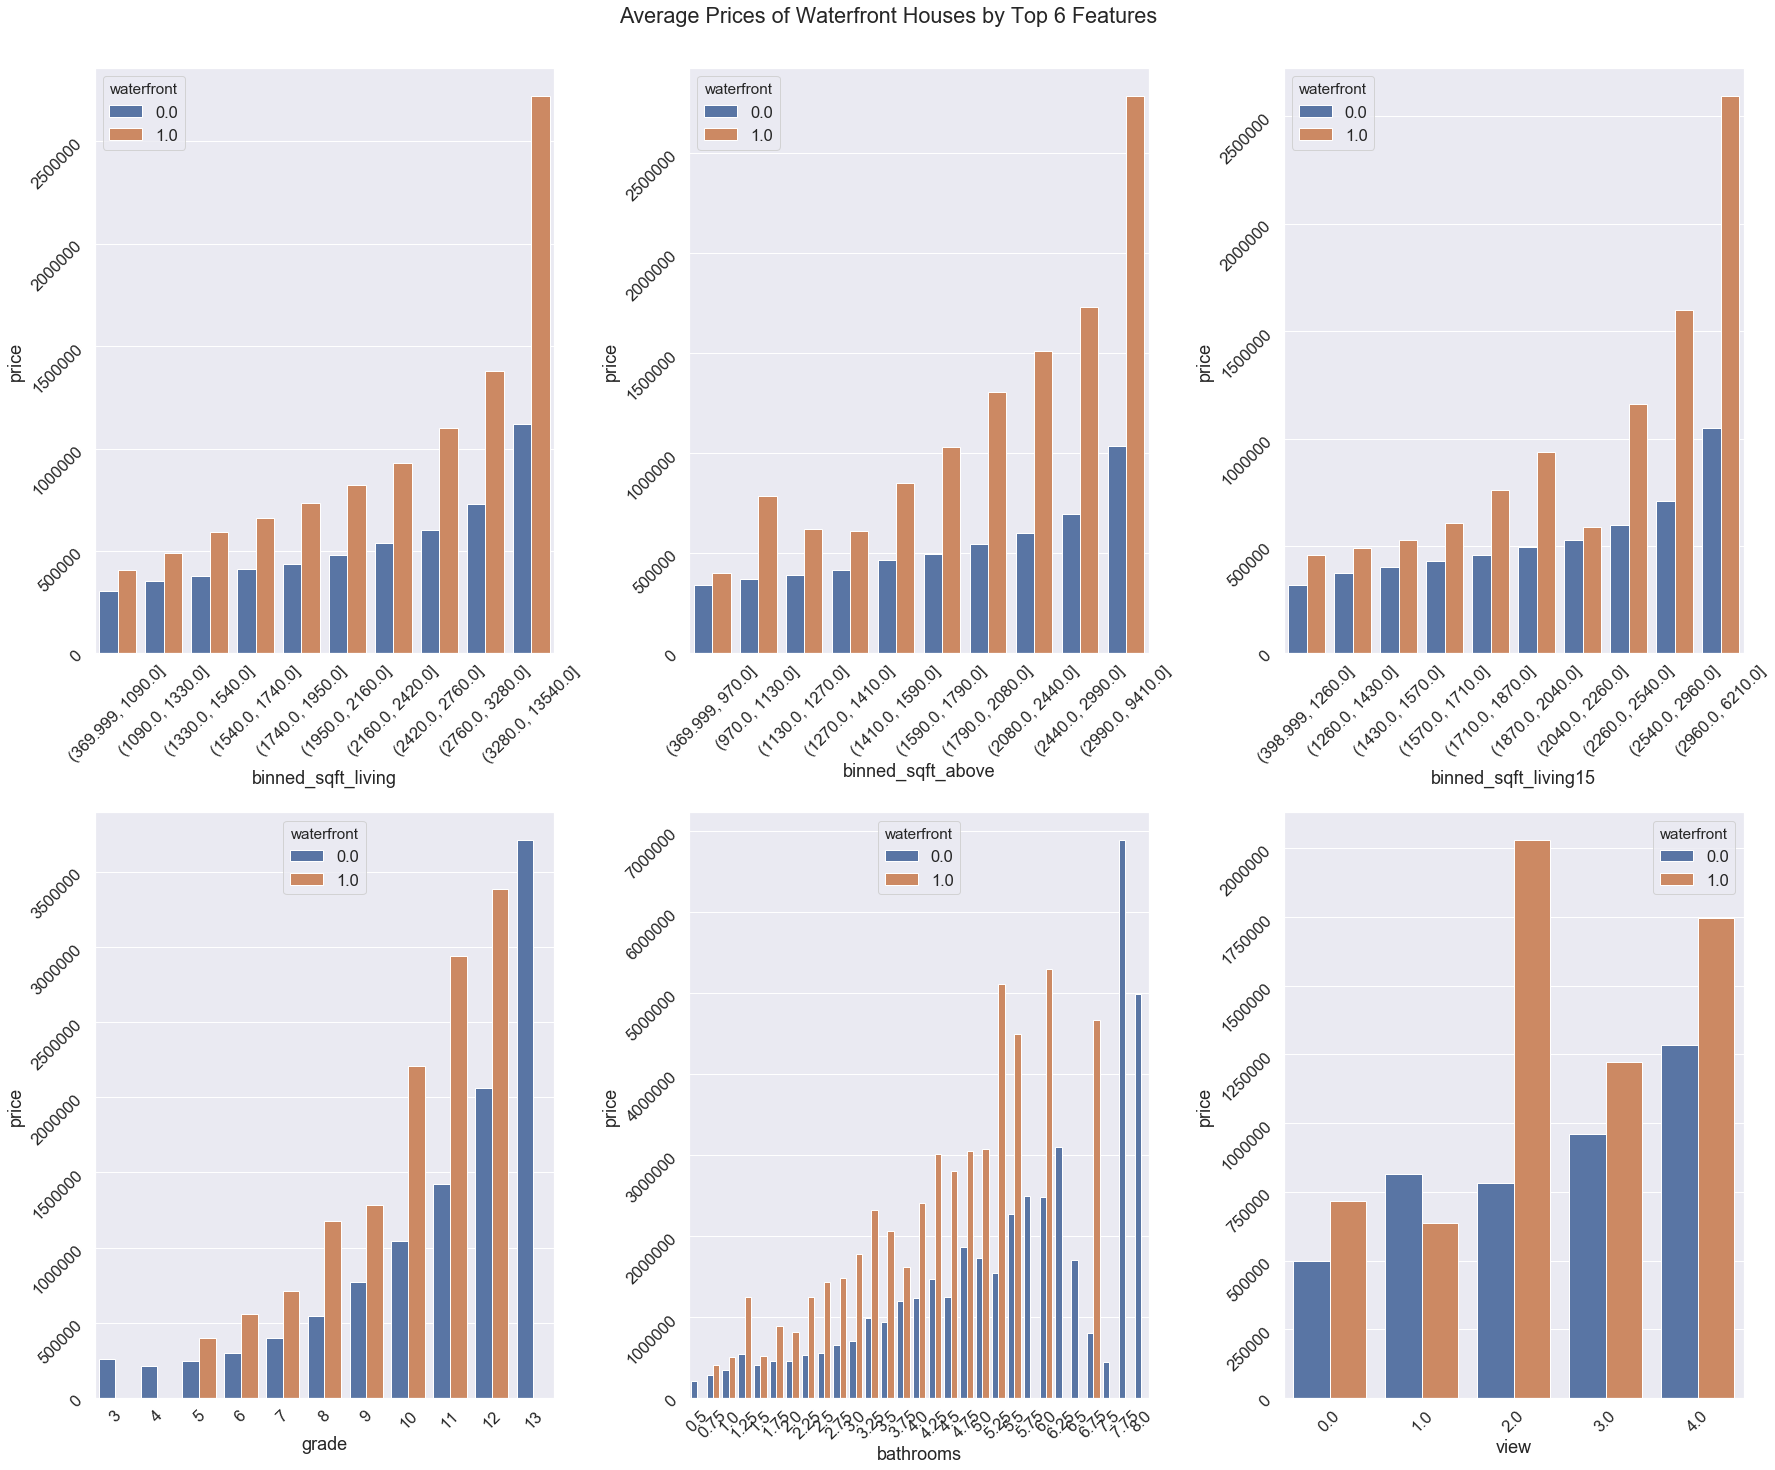

In [37]:
sns.set(font_scale = 1.5)

fig, axes = plt.subplots(2, 3, tight_layout = True, figsize = (25,20))
fig.suptitle('Average Prices of Waterfront Houses by Top 6 Features', y = 1.025)

ax = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1], axes[1, 2]]

for i in range(len(groupby_list)):
    sns.barplot(x = final[i] , y = 'price', data = groupby_list[i], hue = 'waterfront', ax = ax[i])
    ax[i].tick_params(labelrotation = 45)

Issue here is that waterfront house only represents a minor proportion of the total dataset. Great, we have now answered the second question!

## 3. Identify the avg. price and transactions per zipcode. Determine if having higher activity in a particular zipcode drive up prices

Now let's have a look at average prices and activity per zipcode and identify if there are any relationship between activity and prices

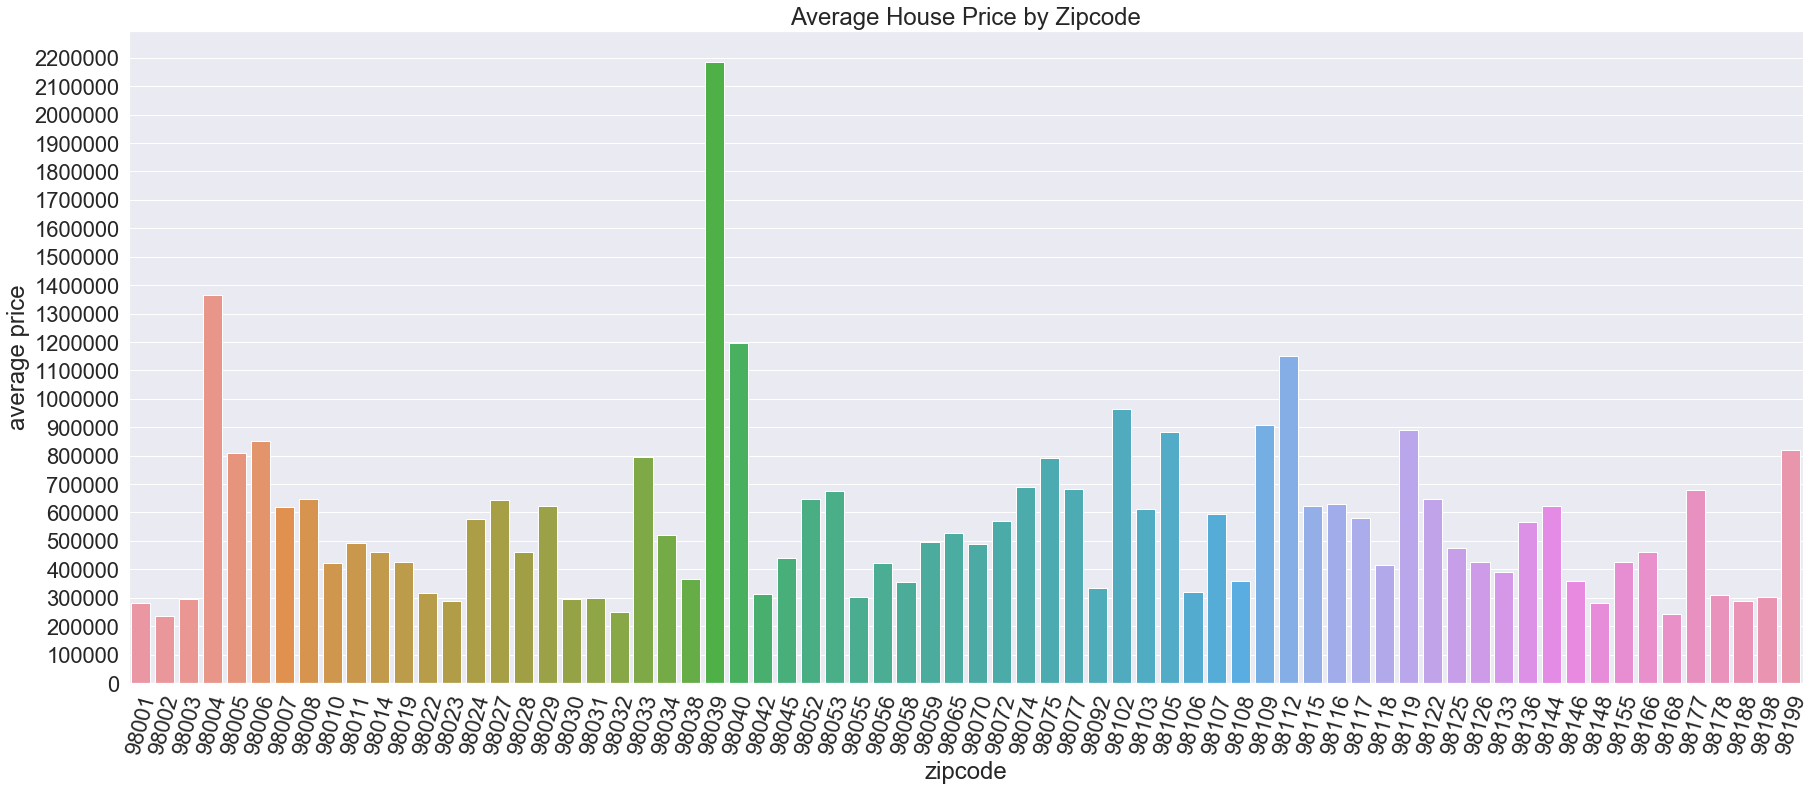

In [38]:
zipcode = df.groupby('zipcode')['price'].mean().reset_index()

sns.set(font_scale = 2)
graph = plt.figure(figsize = (30,12))
graph = sns.barplot(x ='zipcode', y = 'price', data = zipcode)
graph.set_xticklabels(zipcode['zipcode'], rotation = 75)
graph.set_ylabel('average price')
graph.yaxis.set_major_locator(ticker.MultipleLocator(100000))
graph.set_title('Average House Price by Zipcode')
plt.show()

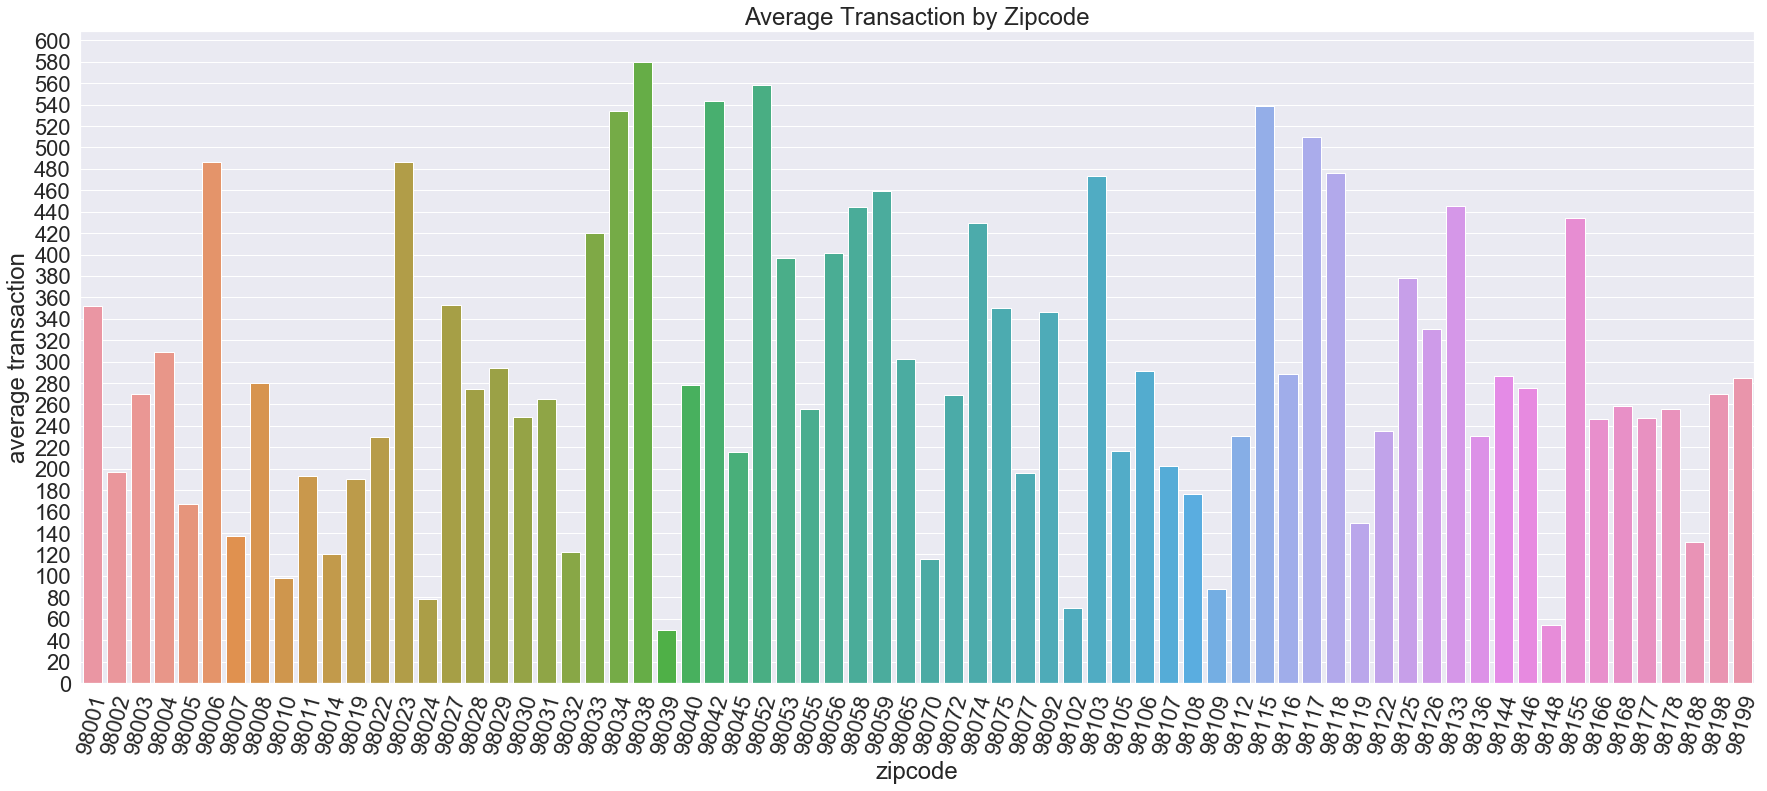

In [39]:
v = df.zipcode.value_counts()
x = v.reset_index()
x.columns = ['zipcode', 'count']
x.sort_values(by = 'zipcode', inplace = True)

sns.set(font_scale = 2)
ax = plt.figure(figsize = (30,12))
ax = sns.barplot(x = 'zipcode', y = 'count', data = x)
ax.set_xticklabels(x.zipcode, rotation =75)
ax.set_ylabel('average transaction')
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.set_title('Average Transaction by Zipcode')

plt.show()

Now let's check if there's any relationship between activity and prices

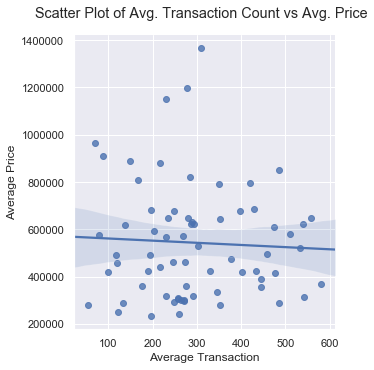

In [40]:
x = df.zipcode.value_counts().reset_index()
x.columns = ['zipcode', 'count']

new = pd.merge(zipcode, x, on = 'zipcode')
new = new.drop(new[new.price > 2000000].index, axis = 0)

sns.set(font_scale = 1)
ax =sns.lmplot(x = 'count', y='price', data =new)
plt.ylabel('Average Price')
plt.xlabel('Average Transaction')
ax.fig.suptitle('Scatter Plot of Avg. Transaction Count vs Avg. Price', y =1.025, x = 0.575)
plt.show()

As per above, there's no real relationship between acitivity and average prices in a zipcode. As such we can conclude that higher activity in a zipcode does not necessarily drive up prices. 

For interactive purposes, below is an map which enables user to click on their respective postcodes and figure out the average price in the region

In [41]:
import folium

coordinates = [df.lat[0], df.long[0]]
x = df.groupby('zipcode')[['lat', 'long', 'price']].mean().sort_values(by = 'price', ascending = False)
y = x.reset_index()
m = folium.Map(
    location = coordinates, 
    zoom_start = 10
)

tooltip = 'Click me!'

for i in y.index:
    folium.Marker([y.lat[i], y.long[i]], 
                  popup = 'Zipcode: {}, Avg Price: {}'.format(y.zipcode[i], int(y.price[i])), 
                  tooltip = tooltip,
                  icon = folium.Icon(icon = 'cloud')).add_to(m)

display(m)

## 4. How have average prices faired over time & when is the best time to sell

Let's now have a look at our final question. One easy way to do this is by plotting average prices / activity by month and day to determine if there are any special patterns.

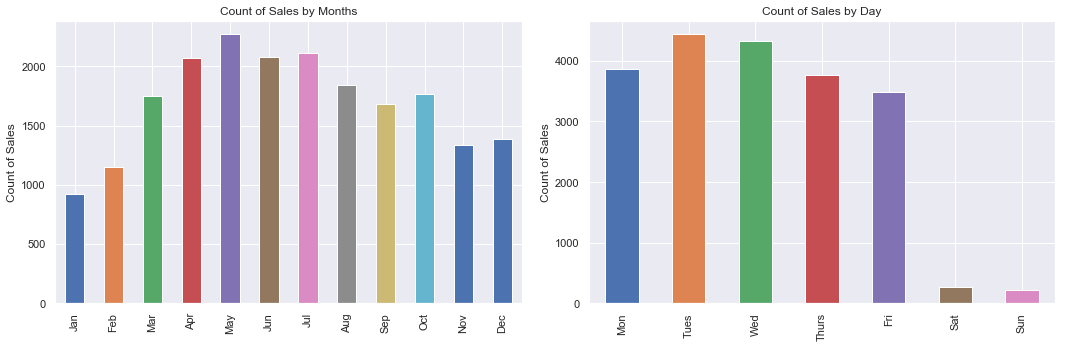

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5), tight_layout = True)

df.month_sold.value_counts(sort = False).plot(kind = 'bar', ax = ax1, title = 'Count of Sales by Months')
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_ylabel('Count of Sales')

df.day_sold.value_counts(sort = False).plot(kind = 'bar', ax = ax2, title = 'Count of Sales by Day')
ax2.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax2.set_ylabel('Count of Sales')

plt.show()

Whilst not conclusive, the month of 'May' tends to have higher activity possibly due to various factors:
     - bonus typically paid in March / April
     - Approaching summer months, hence more house viewings
     - etc.
    
For the days:
    - Not many agents working during weekends
    - Sale close during weekend but takes 2 days for bank clearance

Not very useful given the fairly volatile and the short 12m period. Tried 12 month rolling price, but still not enough data.


Let's now look at if there's any relationship between general activity and price

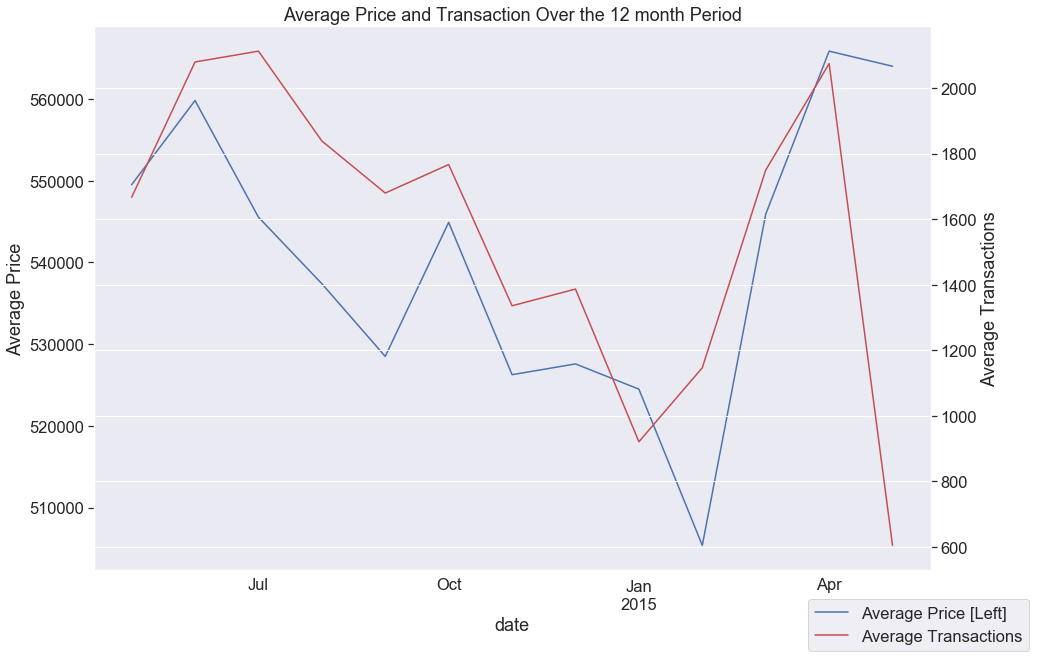

<Figure size 432x288 with 0 Axes>

In [49]:
from pylab import ylabel

w = df.groupby(df.date.dt.to_period('M'))['price'].mean()
w1 = w.reset_index()
w1

z = df.groupby(df.date.dt.to_period('M'))['date'].count()
w1['Average Transactions'] = z.values

sns.set(font_scale = 1.5)
ax = w1.plot(x = 'date', y = 'price', legend = False, figsize = (15,10), grid = False)
ax.yaxis.tick_left()
ylabel('Average Price')

ax2 = ax.twinx()
w1.plot(x = 'date', y = 'Average Transactions', ax =ax2, color = 'r', legend = False)
ax2.yaxis.tick_right()
ylabel('Average Transactions')

ax.figure.legend(('Average Price [Left]', 'Average Transactions'), loc = 'lower right')
ax.set_title('Average Price and Transaction Over the 12 month Period')
plt.show()
plt.savefig('Picture_1.png')

# IGNORE CODE BELOW.

In [ ]:
# [TBD]

fig, axes = plt.subplots(2, 3, tight_layout = True, figsize = (17,12))
ax = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1], axes[1, 2]]

for index in range(len(top6_price_correlation.index)):
    df[top6_price_correlation.index[index]].plot(kind = 'hist', ax = ax[index], normed = True)
    df[top6_price_correlation.index[index]].plot(kind = 'kde', ax = ax[index])
    ax[index].set_title('Distribution & KDE of the {} feature'.format(top6_price_correlation.index[index]))

In [ ]:
# TBD

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, tight_layout = True, figsize = (20,5))

sns.regplot(x = 'sqft_living', y = 'price', data = df_model, ci = 100, ax = ax1)
sns.regplot(x = 'sqft_living_minmax', y = 'price_minmax', data = df_model_minmax, ci = 100, ax = ax2)
sns.regplot(x = 'sqft_living_log', y = 'price_log', data = df_model_log, ci = 100, ax = ax3)

fig.delaxes(ax4)

plt.show()

In [ ]:
# df.groupby('month_sold')['price'].mean().plot(kind = 'bar', ax = ax[1][0], title = 'Average Price by Month')
# ax[1][0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# ax[1][0].set_xlabel('')
# ax[1][0].set_ylabel('Avg. Price')

# df.groupby(df.date.dt.to_period('M'))['price'].mean().plot(ax = ax[1][1], title = 'Evolution of Avg Sale Price', marker = 'D')
# ax[1][1].set_xticks(df.groupby(df.date.dt.to_period('M'))['price'].mean().index)
# plt.xticks(rotation = 45)
# ax[1][1].set_xticklabels(df.groupby(df.date.dt.to_period('M'))['price'].mean().index)
# ax[1][1].set_ylabel('Avg. Price')
# ax[1][1].set_xlabel('')